Epoch 1/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 10170.2305 - mae: 92.0669 - val_loss: 9377.1992 - val_mae: 88.8649
Epoch 2/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9502.6885 - mae: 88.6671 - val_loss: 7867.0962 - val_mae: 79.7767
Epoch 3/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8018.2036 - mae: 79.0803 - val_loss: 4524.7729 - val_mae: 57.2035
Epoch 4/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3831.6482 - mae: 50.4024 - val_loss: 1755.7207 - val_mae: 32.9395
Epoch 5/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2136.1704 - mae: 36.0447 - val_loss: 1712.2499 - val_mae: 32.2420
Epoch 6/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1453.2582 - mae: 28.0648 - val_loss: 1238.3007 - val_mae: 27.4977
Epoch 7/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1376.3512 - mae: 26.5128 - val_loss: 1134.9698 - val_mae: 25.9848
Epoch 8/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1140.6649 - mae: 24.5438 - val_loss: 1114.1942 - val_mae

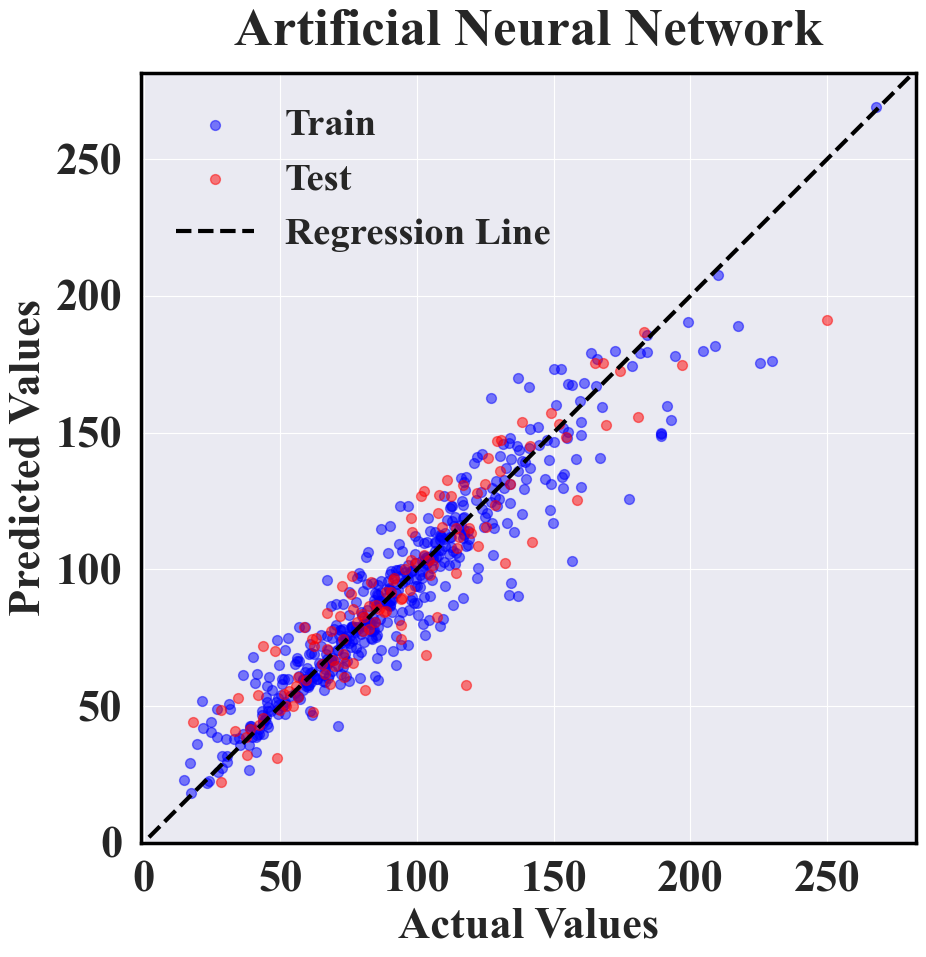

,model,R2_train,MAE_train,MAPE_train,RMSE_train,R2_test,MAE_test,MAPE_test,RMSE_test
0,ANN,0.892848,8.927797,10.959515,13.06768,0.85575,10.818742,13.579545,15.072857


In [1]:
from function import plot_actual_vs_predicted, metrics_to_dataframe
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping

# 读取数据
data = pd.read_csv("data/dataset.csv")

# 数据分割
data['target_class'] = pd.qcut(data['Cs'], q=10, labels=False)
X = data.drop(['Cs', 'target_class'], axis=1)
y = data['Cs']
stratify_column = data['target_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=stratify_column)

# 数据标准化
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 构建 ANN 模型
def create_ann_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(1)  # 回归任务使用单输出层
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# 创建模型
input_shape = (X_train_scaled.shape[1],)
ann_model = create_ann_model(input_shape)

# 设置早停机制
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 训练模型
history = ann_model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,  # 从训练集中分出一部分数据用于验证
    epochs=1000,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# 保存模型
ann_model.save('ann_model.keras')

# 预测
y_train_pred_ann = ann_model.predict(X_train_scaled)
y_test_pred_ann = ann_model.predict(X_test_scaled)

# 计算指标并转换为数据框
ann_metrics = metrics_to_dataframe(y_train, y_train_pred_ann, y_test, y_test_pred_ann, 'ANN')

# 绘制实际与预测的点图
plot_actual_vs_predicted(y_train, y_train_pred_ann, y_test, y_test_pred_ann, 'Artificial Neural Network', 'output/figures/ann.png')

# 显示结果
ann_metrics